In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import precision_recall_curve
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, MultiHeadAttention, LayerNormalization, Conv1D, GlobalAveragePooling1D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Read data

In [2]:
df_fpt = pd.read_csv("FPT.csv", index_col='Date/Time')
df_fpt.index = pd.to_datetime(df_fpt.index, format='%m/%d/%Y %H:%M')

In [3]:
df_msn = pd.read_csv("MSN.csv", index_col='Date/Time')
df_msn.index = pd.to_datetime(df_msn.index, format='%m/%d/%Y %H:%M')

In [4]:
df_pnj = pd.read_csv("PNJ.csv", index_col='Date/Time')
df_pnj.index = pd.to_datetime(df_pnj.index, format='%m/%d/%Y %H:%M')

In [5]:
df_vic = pd.read_csv("VIC.csv", index_col='Date/Time')
df_vic.index = pd.to_datetime(df_vic.index, format='%m/%d/%Y %H:%M')

In [6]:
df = pd.concat([df_fpt, df_msn, df_pnj, df_vic], ignore_index=False)
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,0
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,0
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,0
2018-12-25 09:18:00,FPT,30.74,30.74,30.74,30.74,2120,0
2018-12-25 09:19:00,FPT,30.74,30.74,30.74,30.74,22500,0


In [7]:
df.shape

(459335, 7)

# EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 459335 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         459335 non-null  object 
 1   Open           459335 non-null  float64
 2   High           459335 non-null  float64
 3   Low            459335 non-null  float64
 4   Close          459335 non-null  float64
 5   Volume         459335 non-null  int64  
 6   Open Interest  459335 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 28.0+ MB


<Axes: >

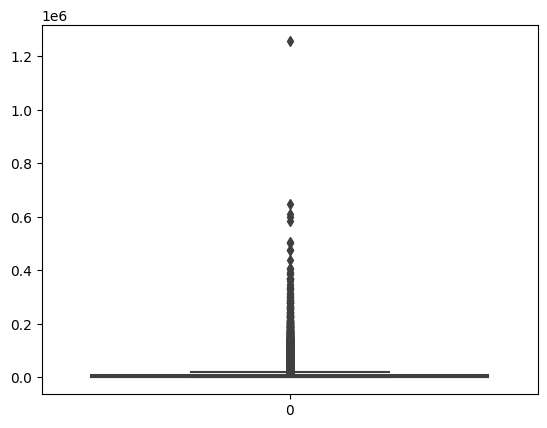

In [9]:
sns.boxplot(df_fpt['Volume'])

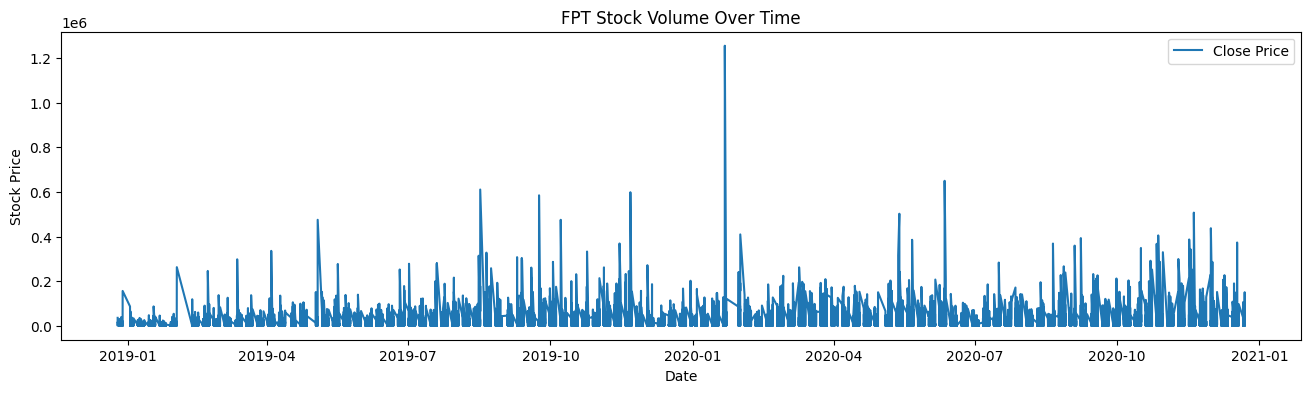

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(df_fpt.index, df_fpt['Volume'], label='Close Price')
#sns.lineplot(x=df_fpt_merged.index, y="Close", data=df_fpt_merged)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Volume Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

In [11]:
# combine all rows into one row each day take the Open as the first value and Close as the last value, High as the max value and Low as the min value, Volume as the sum of all values.
df_fpt_merged = df_fpt.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
df_fpt_merged.head()

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960
2018-12-26,31.04,31.22,30.89,30.89,333590
2018-12-27,31.41,31.52,31.19,31.19,454860
2018-12-28,31.34,31.49,31.19,31.49,387170
2018-12-29,NaN,NaN,NaN,NaN,0


In [12]:
print(df_fpt.loc[df_fpt['Volume'].idxmax()])

print(df_fpt_merged.loc[df_fpt_merged['Volume'].idxmax()])

Ticker               FPT
Open               47.37
High               47.37
Low                47.37
Close              47.37
Volume           1255930
Open Interest          0
Name: 2020-01-21 14:46:00, dtype: object
Open           47.50
High           49.55
Low            47.40
Close          49.35
Volume    6853810.00
Name: 2020-05-13 00:00:00, dtype: float64


In [13]:
df_fpt_merged.isna().sum()

Open      230
High      230
Low       230
Close     230
Volume      0
dtype: int64

In [14]:
df_fpt_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2018-12-25 to 2020-12-22
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    499 non-null    float64
 1   High    499 non-null    float64
 2   Low     499 non-null    float64
 3   Close   499 non-null    float64
 4   Volume  729 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 50.3 KB


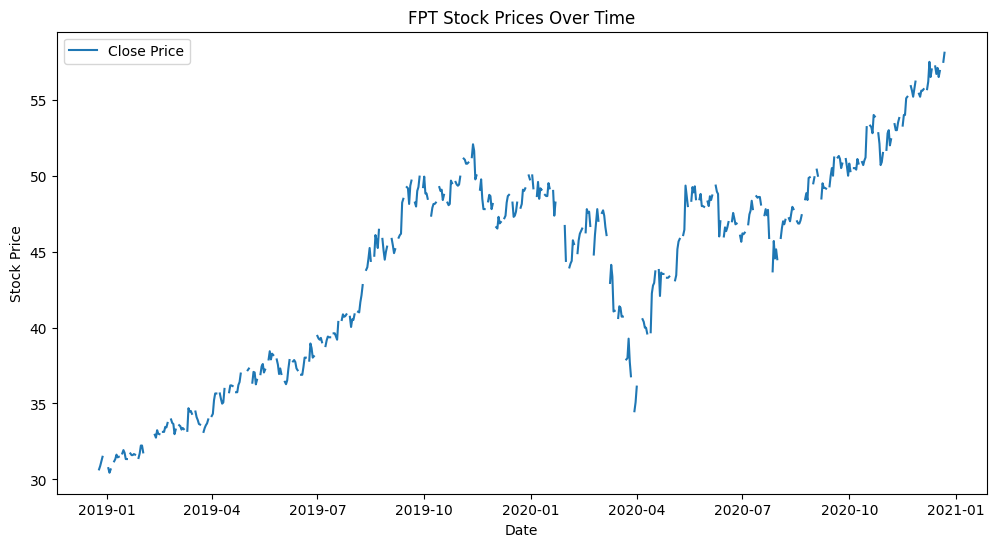

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt_merged.index, df_fpt_merged['Close'], label='Close Price')
#sns.lineplot(x=df_fpt_merged.index, y="Close", data=df_fpt_merged)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Prices Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

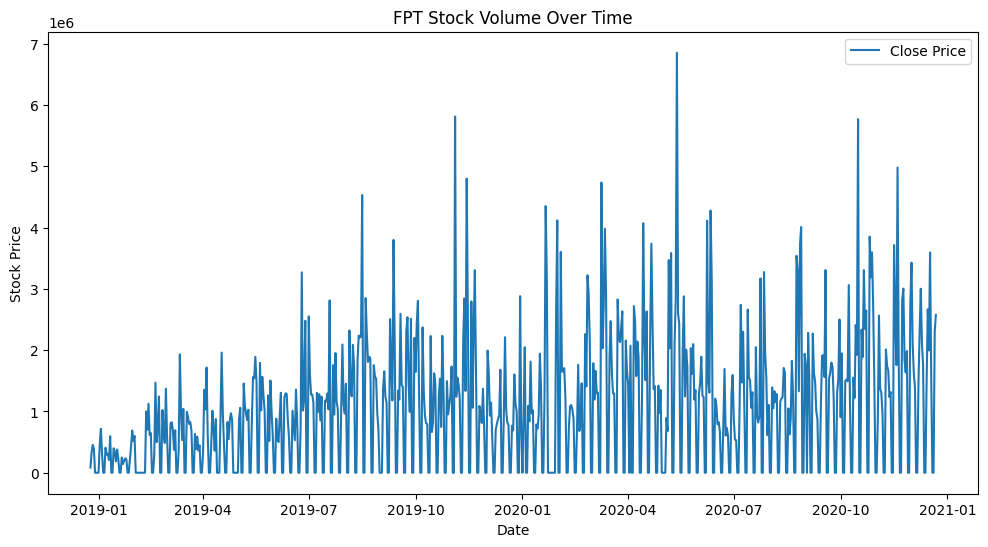

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt_merged.index, df_fpt_merged['Volume'], label='Close Price')
#sns.lineplot(x=df_fpt_merged.index, y="Close", data=df_fpt_merged)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Volume Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

In [17]:
# fill missing values with linear regression model (interpolate method)
df_fpt_merged['Open'] = df_fpt_merged['Open'].interpolate(method='linear')
df_fpt_merged['High'] = df_fpt_merged['High'].interpolate(method='linear')
df_fpt_merged['Low'] = df_fpt_merged['Low'].interpolate(method='linear')
df_fpt_merged['Close'] = df_fpt_merged['Close'].interpolate(method='linear')
df_fpt_merged['Volume'] = df_fpt_merged['Volume'].interpolate(method='linear')
df_fpt_merged.head()

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.89,30.890,30.590,30.66,84960
2018-12-26,31.04,31.220,30.890,30.89,333590
2018-12-27,31.41,31.520,31.190,31.19,454860
2018-12-28,31.34,31.490,31.190,31.49,387170
2018-12-29,31.31,31.482,31.092,31.34,0


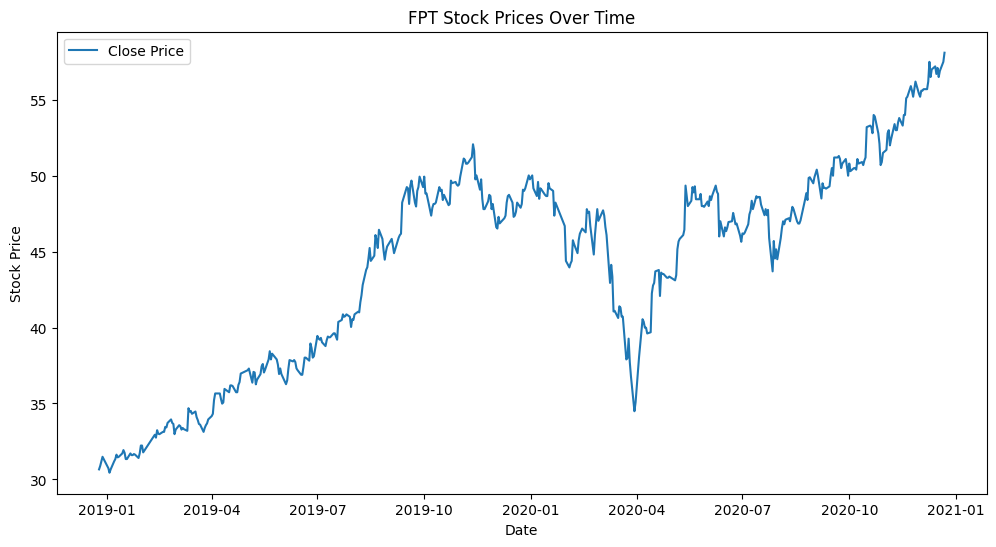

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt_merged.index, df_fpt_merged['Close'], label='Close Price')
#sns.lineplot(x=df_fpt_merged.index, y="Close", data=df_fpt_merged)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Prices Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

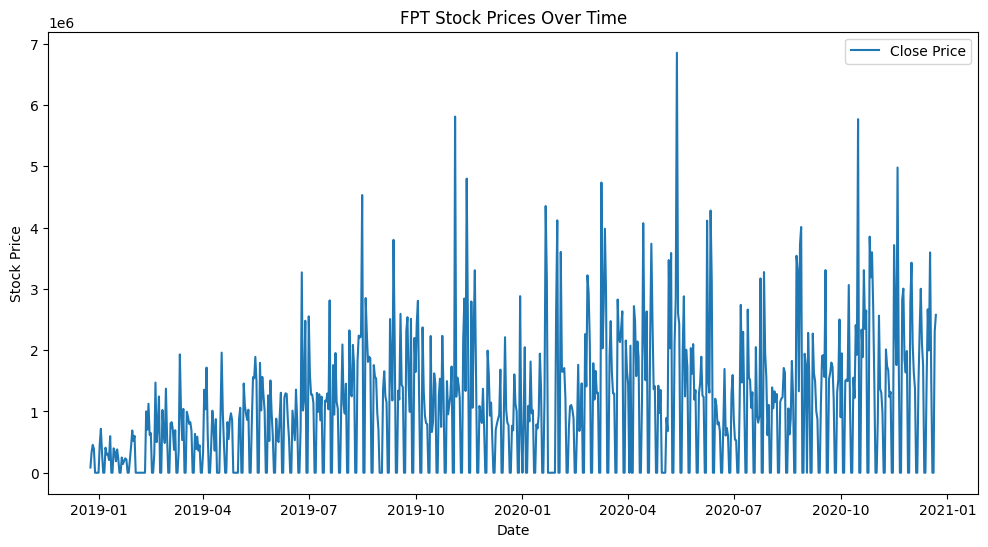

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt_merged.index, df_fpt_merged['Volume'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Prices Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

In [20]:
df_fpt = df_fpt_merged

# Model Analysis (RNN vs Transfromer)

In [21]:
df_fpt

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.890000,30.890000,30.590,30.66,84960
2018-12-26,31.040000,31.220000,30.890,30.89,333590
2018-12-27,31.410000,31.520000,31.190,31.19,454860
2018-12-28,31.340000,31.490000,31.190,31.49,387170
2018-12-29,31.310000,31.482000,31.092,31.34,0
...,...,...,...,...,...
2020-12-18,56.500000,57.000000,56.500,56.90,1532820
2020-12-19,56.766667,57.266667,56.700,57.10,0
2020-12-20,57.033333,57.533333,56.900,57.30,0


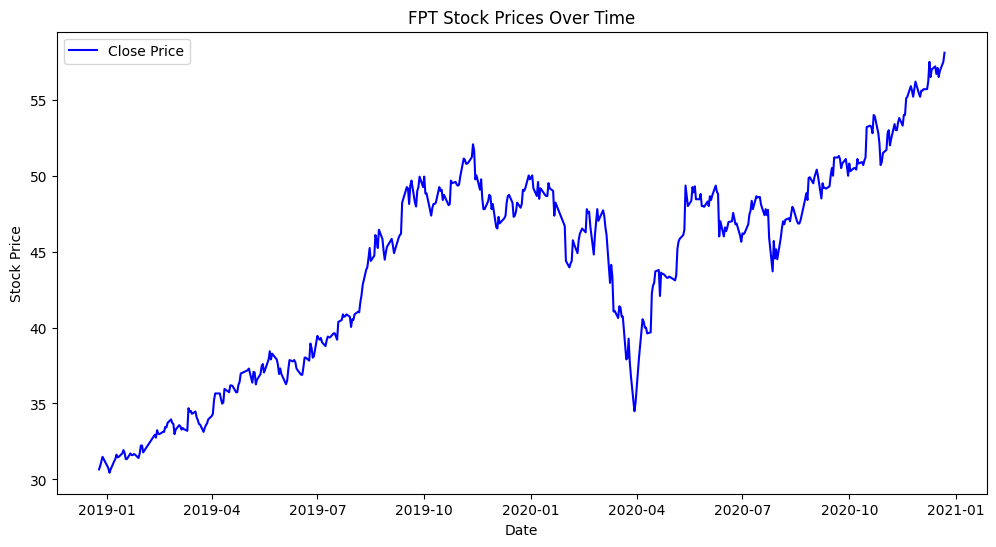

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index, df_fpt['Close'], label='Close Price', color='blue')
#plt.plot(df_fpt['Date/Time'], df_fpt['Open'], label='Open Price', color='green', linestyle='dashed')
#plt.plot(df_fpt['Date/Time'], df_fpt['High'], label='High Price', color='red', linestyle='dotted')
#plt.plot(df_fpt['Date/Time'], df_fpt['Low'], label='Low Price', color='purple', linestyle='dotted')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Prices Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

In [23]:
df_fpt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2018-12-25 to 2020-12-22
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    729 non-null    float64
 1   High    729 non-null    float64
 2   Low     729 non-null    float64
 3   Close   729 non-null    float64
 4   Volume  729 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 50.3 KB


Normalize data

In [24]:
df_fpt = df_fpt[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize the data
scaler = MinMaxScaler()
df_fpt_normalized = scaler.fit_transform(df_fpt)

In [25]:
# Define a function to create the input sequences and labels
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the sequence length
sequence_length = 30 # 30 days

Without validation

In [26]:
# # Create sequences and labels
# sequences, labels = create_sequences(df_fpt_normalized, sequence_length)

# # Use the first 80% of the data for training
# train_size = int(len(sequences) * 0.8)
# X_train, y_train = sequences[:train_size], labels[:train_size]

# # Use the remaining 20% as the test set
# X_test, y_test = sequences[train_size:], labels[train_size:]
# print(X_train.shape)
# print(X_test.shape)

In [49]:
df_fpt_normalized.shape

(729, 5)

With validation

In [27]:
sequences, labels = create_sequences(df_fpt_normalized, sequence_length)

# Split the data into train (70%), validation (10%), and test (20%) sets
train_size = int(len(sequences) * 0.7)
val_size = int(len(sequences) * 0.1)

X_train, y_train = sequences[:train_size], labels[:train_size]
X_val, y_val = sequences[train_size:train_size + val_size], labels[train_size:train_size + val_size]
X_test, y_test = sequences[train_size + val_size:], labels[train_size + val_size:]
print(X_train.shape)
print(X_test.shape)

(489, 30, 5)
(141, 30, 5)


In [28]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(5))

# Compile the model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history_gru = model_gru.fit(X_train, y_train, 
                            epochs=300, batch_size=64, 
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss_gru = model_gru.evaluate(X_test, y_test)

Epoch 1/300
8/8 [==============================] - 3s 83ms/step - loss: 0.1782 - val_loss: 0.1293
Epoch 2/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0533 - val_loss: 0.0142
Epoch 3/300
8/8 [==============================] - 0s 17ms/step - loss: 0.0236 - val_loss: 0.0101
Epoch 4/300
8/8 [==============================] - 0s 19ms/step - loss: 0.0227 - val_loss: 0.0087
Epoch 5/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0167 - val_loss: 0.0084
Epoch 6/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0156 - val_loss: 0.0081
Epoch 7/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0136 - val_loss: 0.0065
Epoch 8/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0120 - val_loss: 0.0058
Epoch 9/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0116 - val_loss: 0.0056
Epoch 10/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0118 - val_loss: 0.0057
Epoch 11/300
8/8 [=

In [29]:
# Build BiLSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(LSTM(50))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(5))

# Compile the model
model_bilstm.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history_bilstm = model_bilstm.fit(X_train, y_train, 
                                  epochs=300, batch_size=64, 
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss_bilstm = model_bilstm.evaluate(X_test, y_test)

Epoch 1/300
8/8 [==============================] - 7s 232ms/step - loss: 0.0773 - val_loss: 0.0270
Epoch 2/300
8/8 [==============================] - 0s 45ms/step - loss: 0.0228 - val_loss: 0.0128
Epoch 3/300
8/8 [==============================] - 0s 48ms/step - loss: 0.0172 - val_loss: 0.0094
Epoch 4/300
8/8 [==============================] - 0s 45ms/step - loss: 0.0140 - val_loss: 0.0067
Epoch 5/300
8/8 [==============================] - 0s 42ms/step - loss: 0.0121 - val_loss: 0.0058
Epoch 6/300
8/8 [==============================] - 0s 44ms/step - loss: 0.0104 - val_loss: 0.0059
Epoch 7/300
8/8 [==============================] - 0s 41ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 8/300
8/8 [==============================] - 0s 41ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 9/300
8/8 [==============================] - 0s 42ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 10/300
8/8 [==============================] - 0s 42ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 11/300
8/8 [

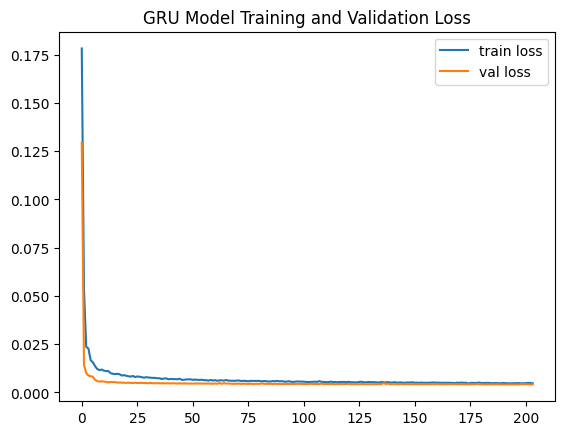

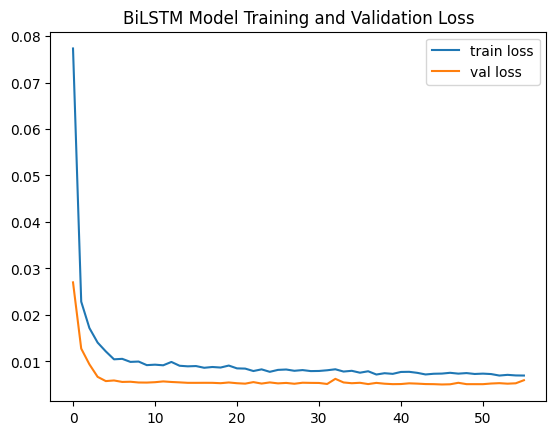

In [30]:
def plot_history(history, title):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot GRU model history
plot_history(history_gru, 'GRU Model Training and Validation Loss')

# Plot BiLSTM model history
plot_history(history_bilstm, 'BiLSTM Model Training and Validation Loss')

In [31]:
# Predictions on the test set
test_predictions_gru = model_gru.predict(X_test)
test_predictions_bilstm = model_bilstm.predict(X_test)

# Inverse transform the normalized data to get the actual values
test_predictions_gru = scaler.inverse_transform(test_predictions_gru)
test_predictions_bilstm = scaler.inverse_transform(test_predictions_bilstm)
y_test_actual = scaler.inverse_transform(y_test)
y_train_actual = scaler.inverse_transform(y_train)
y_val_actual = scaler.inverse_transform(y_val)

5/5 [==============================] - 1s 8ms/step


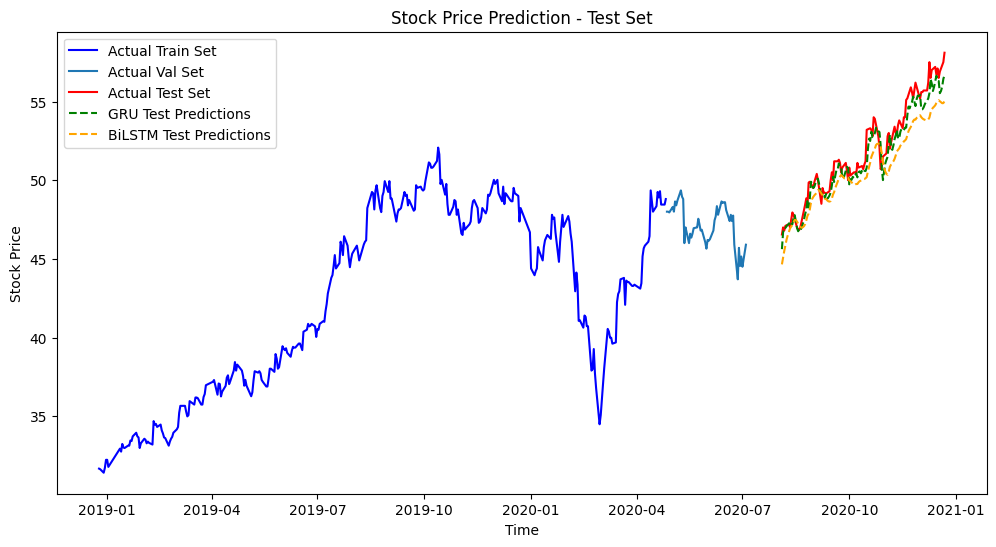

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[:train_size], y_train_actual[:, 3], label='Actual Train Set', color='blue')
plt.plot(df_fpt.index[train_size:train_size + val_size], y_val_actual[:, 3], label='Actual Val Set')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

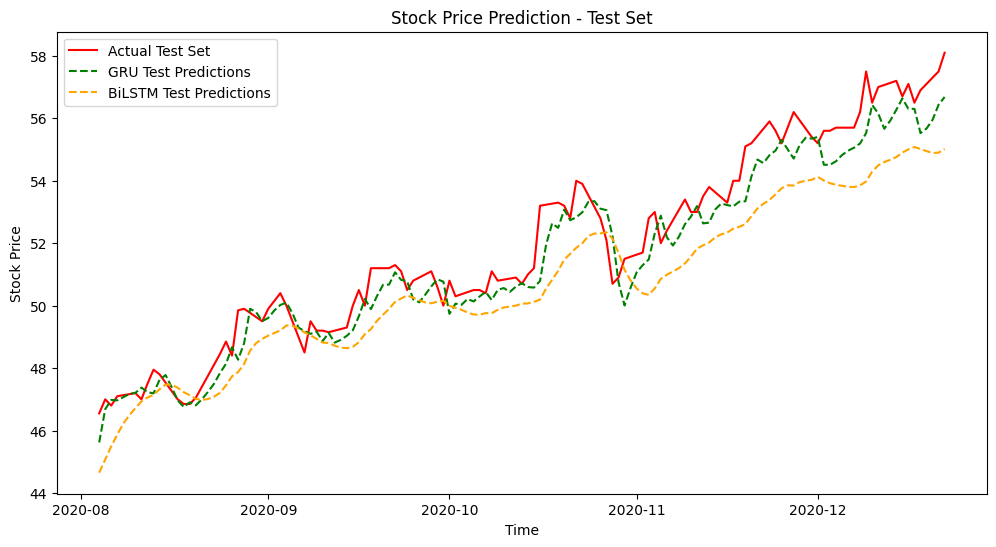

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 23ms/step


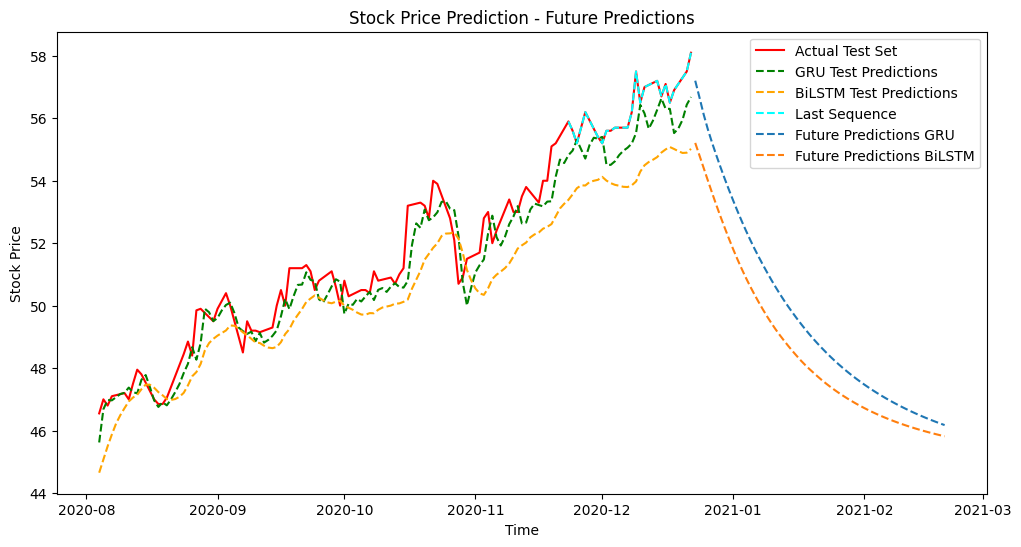

In [34]:
# Use the last `sequence_length` data points from the original data to create a new sequence
last_sequence = df_fpt_normalized[-sequence_length:]

# Create a copy of the last sequence for modification
X_future_gru = last_sequence.copy()
X_future_bilstm = last_sequence.copy()

# Number of future data points to predict
num_future_points = 60  # 2 months

# Make predictions for the future data points
for i in range(num_future_points):
    # Predict the next data point
    next_point_gru = model_gru.predict(np.expand_dims(X_future_gru[-sequence_length:], axis=0))
    next_point_bilstm = model_bilstm.predict(np.expand_dims(X_future_bilstm[-sequence_length:], axis=0))

    # Append the predicted points to X_future
    X_future_gru = np.vstack([X_future_gru, next_point_gru[0]])
    X_future_bilstm = np.vstack([X_future_bilstm, next_point_bilstm[0]])

# Inverse transform the normalized data to get the actual values for X_future
X_future_actual_gru = scaler.inverse_transform(X_future_gru)
X_future_actual_bilstm = scaler.inverse_transform(X_future_bilstm)

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index, df_fpt['Close'], label='Actual Data', color='blue')
#plt.plot(df_fpt.index[train_size + sequence_length:], y_test_actual[:,3], label='Actual Test Set', color='red')
#plt.plot(df_fpt.index[train_size + sequence_length:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
#plt.plot(df_fpt.index[train_size + sequence_length:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')

plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')


plt.plot(df_fpt.index[-sequence_length:], df_fpt['Close'][-sequence_length:], label='Last Sequence', color='cyan', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_gru[-num_future_points:, 3], label='Future Predictions GRU', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_bilstm[-num_future_points:, 3], label='Future Predictions BiLSTM', linestyle='dashed')

plt.title('Stock Price Prediction - Future Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Transfomer

In [35]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [36]:
def build_transformer_model(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0):
    n_timesteps, n_features, n_outputs = sequence_length, 5, 5  
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs

    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)

    outputs = Dense(n_outputs, activation='linear')(x)  
    return tf.keras.Model(inputs, outputs)


In [37]:
# Define hyperparameters
head_size = 128
num_heads = 4
ff_dim = 2
num_trans_blocks = 4
mlp_units = [256]
dropout = 0.10
mlp_dropout = 0.10

# Build and compile the model
transformer_model = build_transformer_model(
    head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout
)

transformer_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'],
)

early_stopping2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = transformer_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=300,
    #validation_split=0.2,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping2],
    verbose=1
)

Epoch 1/300
16/16 [==============================] - 9s 121ms/step - loss: 0.0467 - mae: 0.1588 - mape: 9301478.0000 - val_loss: 0.0213 - val_mae: 0.1272 - val_mape: 15060701.0000
Epoch 2/300
16/16 [==============================] - 1s 80ms/step - loss: 0.0233 - mae: 0.1197 - mape: 10920063.0000 - val_loss: 0.0310 - val_mae: 0.1618 - val_mape: 10609048.0000
Epoch 3/300
16/16 [==============================] - 1s 78ms/step - loss: 0.0197 - mae: 0.1077 - mape: 8177743.0000 - val_loss: 0.0218 - val_mae: 0.1315 - val_mape: 13157040.0000
Epoch 4/300
16/16 [==============================] - 1s 80ms/step - loss: 0.0135 - mae: 0.0874 - mape: 8965653.0000 - val_loss: 0.0064 - val_mae: 0.0531 - val_mape: 9672350.0000
Epoch 5/300
16/16 [==============================] - 1s 80ms/step - loss: 0.0117 - mae: 0.0792 - mape: 9302889.0000 - val_loss: 0.0062 - val_mae: 0.0517 - val_mape: 10399229.0000
Epoch 6/300
16/16 [==============================] - 1s 81ms/step - loss: 0.0107 - mae: 0.0763 - mape: 9

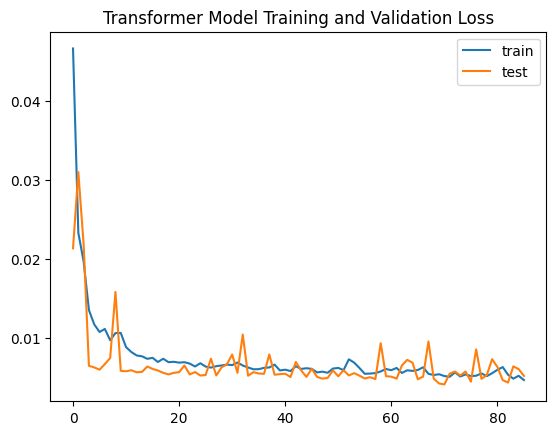

In [38]:
def plot_history_trasnformer(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title(title)
    plt.legend()
    plt.show()

plot_history_trasnformer(history, 'Transformer Model Training and Validation Loss')

In [39]:
# Make predictions on the test set
test_predictions_transformer = transformer_model.predict(X_test)
print(test_predictions_transformer.shape)
# Inverse transform the predictions and labels to the original scale
test_predictions_transformer = scaler.inverse_transform(test_predictions_transformer)


5/5 [==============================] - 0s 21ms/step
(141, 5)


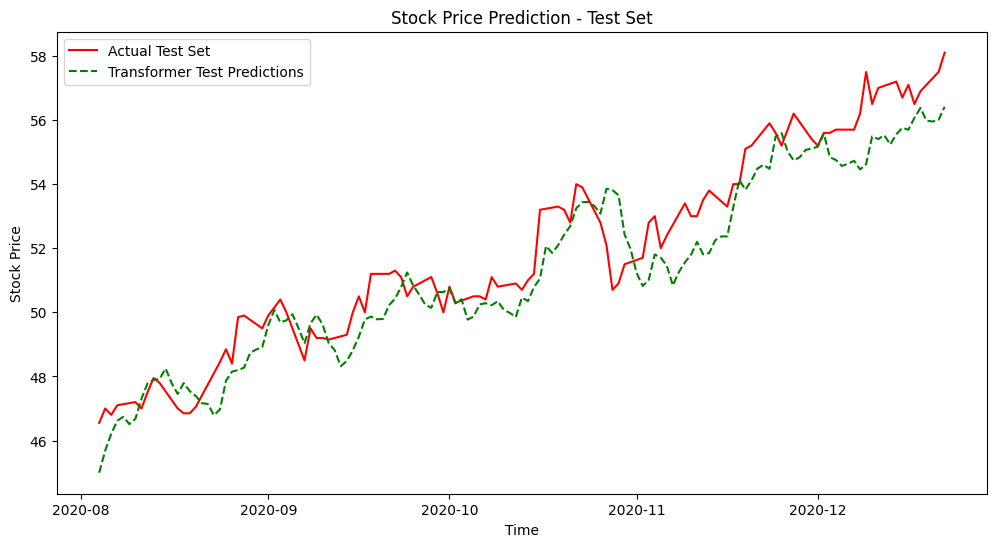

In [40]:
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index[:train_size], y_train_actual[:, 3], label='Actual Train Set', color='blue')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', color='green', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 22ms/step


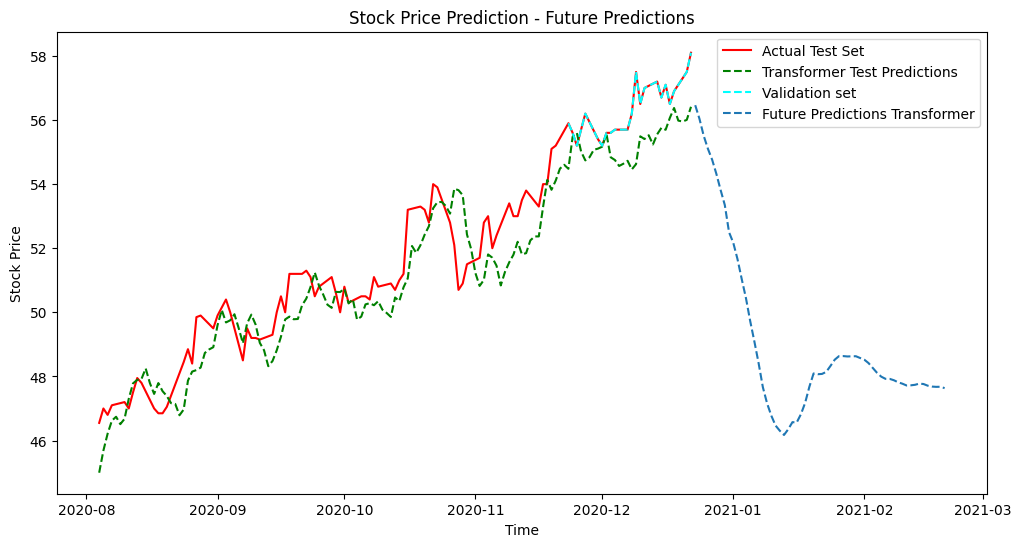

In [41]:
# Use the last `sequence_length` data points from the original data to create a new sequence
last_sequence = df_fpt_normalized[-sequence_length:]

# Create a copy of the last sequence for modification
X_future_transformer = last_sequence.copy()

# Number of future data points to predict
num_future_points = 60  # 2 months

# Make predictions for the future data points
for i in range(num_future_points):
    # Predict the next data point
    next_point_transformer = transformer_model.predict(np.expand_dims(X_future_transformer[-sequence_length:], axis=0))
   
    # Append the predicted points to X_future
    X_future_transformer = np.vstack([X_future_transformer, next_point_transformer[0]])
    
# Inverse transform the normalized data to get the actual values for X_future
X_future_actual_transformer = scaler.inverse_transform(X_future_transformer)

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index, df_fpt['Close'], label='Actual Data', color='blue')
#plt.plot(df_fpt.index[train_size + sequence_length:], y_test_actual[:,3], label='Actual Test Set', color='red')

plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', color='green', linestyle='dashed')


plt.plot(df_fpt.index[-sequence_length:], df_fpt['Close'][-sequence_length:], label='Validation set', color='cyan', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_transformer[-num_future_points:, 3], label='Future Predictions Transformer', linestyle='dashed')

plt.title('Stock Price Prediction - Future Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


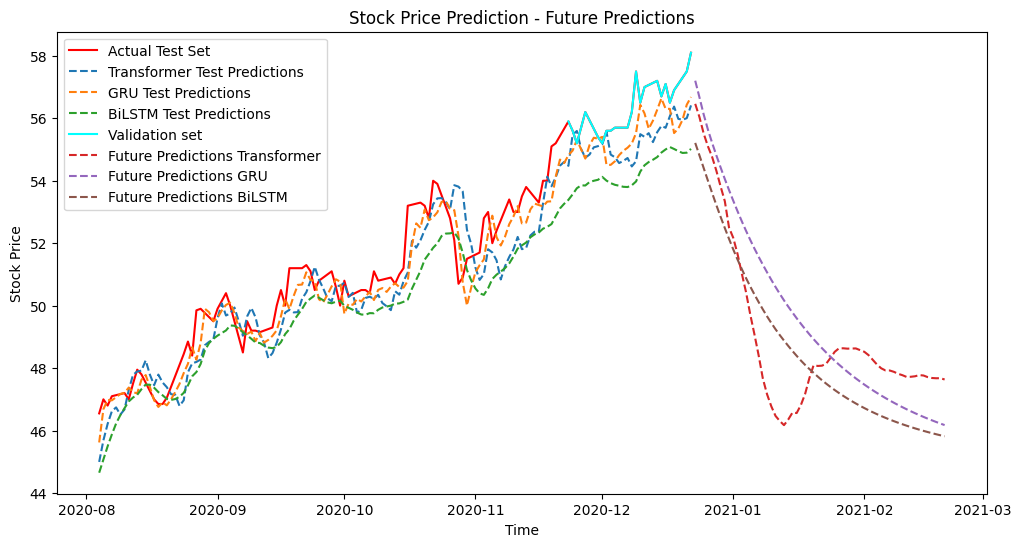

In [42]:
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index, df_fpt['Close'], label='Actual Data', color='blue')

plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', linestyle='dashed')


plt.plot(df_fpt.index[-sequence_length:], df_fpt['Close'][-sequence_length:], label='Validation set', color='cyan')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_transformer[-num_future_points:, 3], label='Future Predictions Transformer', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_gru[-num_future_points:, 3], label='Future Predictions GRU', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_bilstm[-num_future_points:, 3], label='Future Predictions BiLSTM', linestyle='dashed')


plt.title('Stock Price Prediction - Future Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [43]:
# SARIMA Model
def train_arima_model(train_data):
    stepwise_model = auto_arima(train_data, start_p=2, start_q=2,
                            max_p=5, max_q=5, m=7, seasonal=True,
                            d=None, D=None, trace=True,
                            error_action='ignore',
                            suppress_warnings=True, stepwise=True)
    return stepwise_model

# Holt-Winters Model
def train_holt_winters_model(train_data):
    model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=7)
    fitted_model = model.fit()
    return fitted_model

(171,)


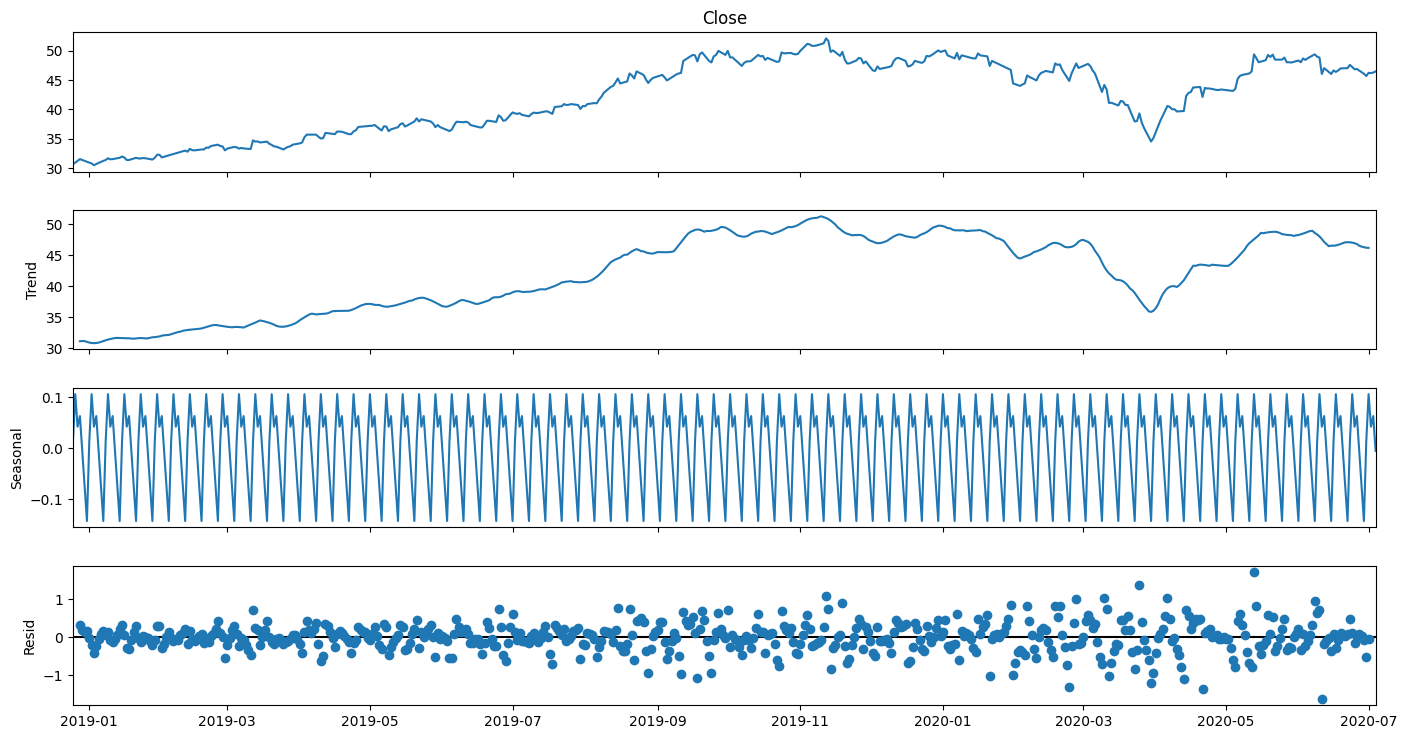

In [80]:
train_set = df_fpt['Close'][: train_size + val_size]
test_set = df_fpt['Close'][train_size + val_size :]


# Decompose the time series using an additive model
str_results = seasonal_decompose(train_set, period=7) # 7 days
fig = str_results.plot()
fig.set_size_inches((16, 8))
print(test_set.shape)


In [61]:
trend = str_results.trend

#remove null values
trend = trend.dropna()
print(trend.isna().sum())

0


In [69]:
# reshape the data to be (489, 30, 1)
arima_m = train_arima_model(trend) # 3 here is the index of the Close price and reshape(-1) to make it 1D array

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-144.898, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1119.405, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-573.264, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-137.792, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-968.165, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-1164.752, Time=0.97 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-146.316, Time=0.38 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=-1165.131, Time=1.43 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=-1118.756, Time=0.61 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=-1166.346, T

In [128]:

prediction = arima_m.predict(n_periods=len(test_set))
print(prediction.tail(), test_set.shape)

# add seasonality and residual to the prediction but retain the shape of the test set
for i in range(len(prediction) -3):
    # if str_results.resid is null, then prediction[i] = prediction[i] + str_results.seasonal[-len(prediction) + i]
    if str_results.resid[-len(prediction) + i] is None:
        prediction[i] = prediction[i] + str_results.seasonal[-len(prediction) + i] + 0
    else:
        prediction[i] = prediction[i] + str_results.seasonal[-len(prediction) + i] + str_results.resid[-len(prediction) + i]
print(prediction.tail())

2020-12-15    51.888621
2020-12-16    51.917006
2020-12-17    51.945383
2020-12-18    51.973750
2020-12-19    52.002109
Freq: D, dtype: float64 (171,)
2020-12-15    51.367192
2020-12-16    51.967006
2020-12-17    51.945383
2020-12-18    51.973750
2020-12-19    52.002109
Freq: D, dtype: float64


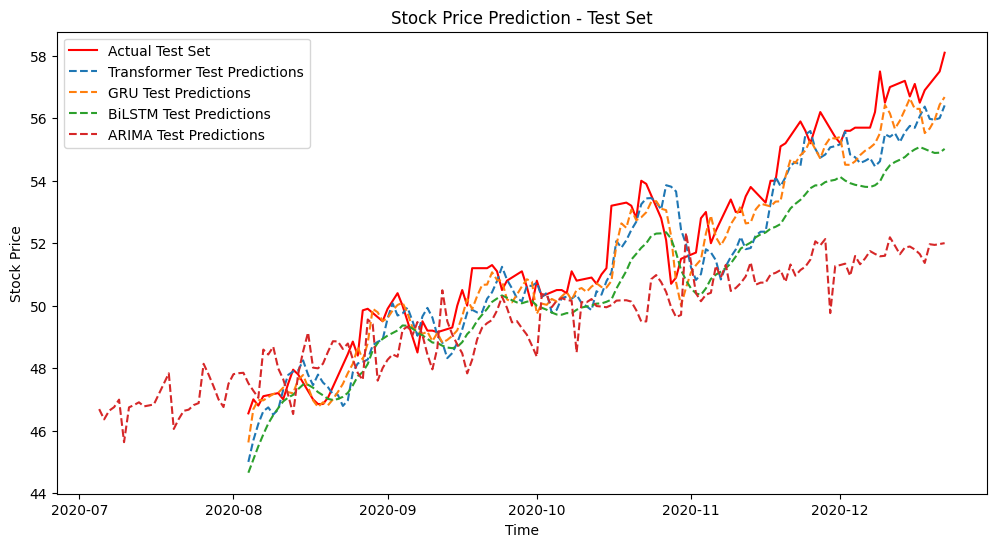

In [131]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + val_size:], prediction, label='ARIMA Test Predictions', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [100]:
print(prediction.tail())

2020-12-15    51.367192
2020-12-16    51.967006
2020-12-17          NaN
2020-12-18          NaN
2020-12-19          NaN
Freq: D, dtype: float64


(30,)
diff is:  5.802946669299381


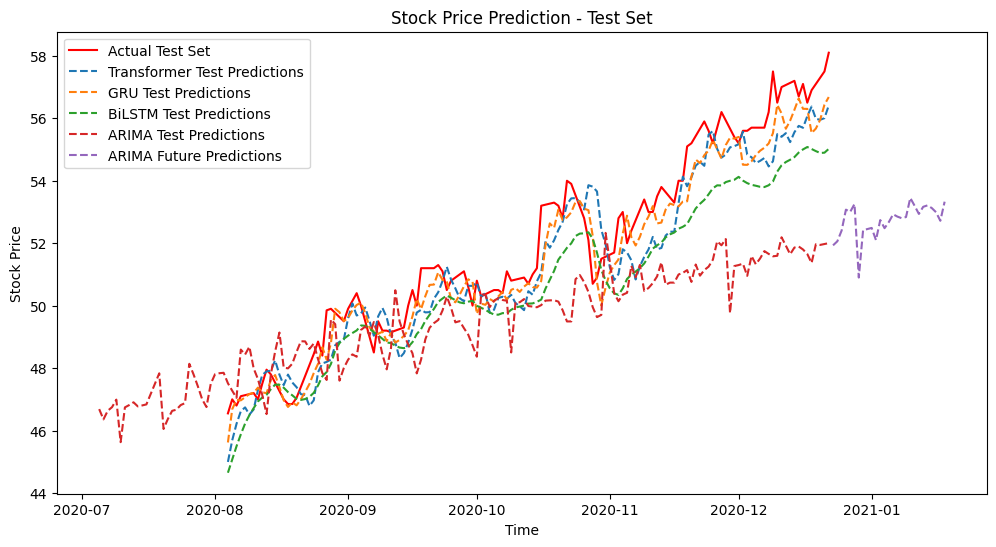

In [132]:
# predict the future after the test set 1 month (30 days)
future_prediction = arima_m.predict(n_periods=30)
print(future_prediction.shape)

# connect the future prediction to the test set by adding the difference between the last value of the test set and the first value of the future prediction
diff = prediction[-4] - future_prediction[0]
print("diff is: ", diff)
for i in range(len(future_prediction)):
    future_prediction[i] = future_prediction[i] + diff

# add seasonality and residual to the prediction but retain the shape of the test set
for i in range(len(future_prediction)):
    future_prediction[i] = future_prediction[i] + str_results.seasonal[-len(future_prediction) + i] + str_results.resid[-len(future_prediction) + i]

plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + val_size:], prediction, label='ARIMA Test Predictions', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=31, freq='D')[1:], future_prediction, label='ARIMA Future Predictions', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [141]:
def train_holt_winters_model(train_data):
    model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=15)
    fitted_model = model.fit()
    return fitted_model

holt_winters_model = train_holt_winters_model(train_set)

holt_winters_model.forecast(steps=len(test_set))

2020-07-05    46.563047
2020-07-06    46.501403
2020-07-07    46.489580
2020-07-08    46.701990
2020-07-09    46.671341
                ...    
2020-12-18    51.148698
2020-12-19    51.136874
2020-12-20    51.349285
2020-12-21    51.318635
2020-12-22    51.291091
Freq: D, Length: 171, dtype: float64

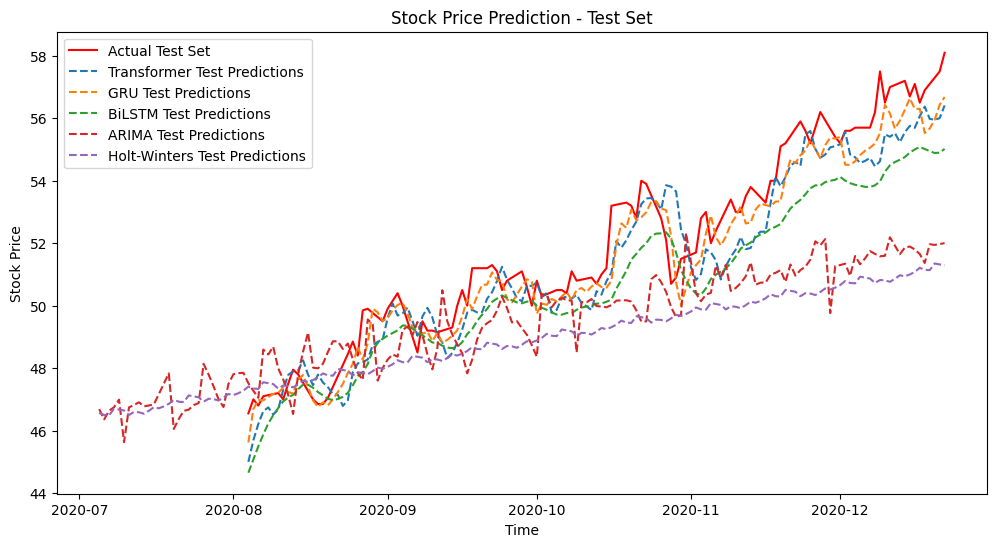

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + val_size:], prediction, label='ARIMA Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + val_size:], holt_winters_model.forecast(steps=len(test_set)), label='Holt-Winters Test Predictions', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()